In [1]:
import sqlite3
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import tree
from sklearn.preprocessing import RobustScaler 

In [2]:
connection = sqlite3.connect("museum_list.db") 
crsr = connection.cursor()
sql_command = """SELECT * FROM museum;"""
crsr.execute(sql_command)
myresult = crsr.fetchall()
x = []
y = []
for row in myresult:
    x.append(row[4])
    y.append(row[2])
x = np.asarray(x).reshape(-1,1)
y = np.asarray(y)

## Data Stats

In [3]:
print("Mean of input: ", x.mean())
print("Mean of output: ", y.mean())
print("Variance of input: ", x.var())


Mean of input:  12701781.37704918
Mean of output:  3552321.8524590163
Variance of input:  55045539245869.02


# Plot the Box plot to see the distribution and show the outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x120d18d30>,
 'caps': [<matplotlib.lines.Line2D at 0x120d37400>,
 'boxes': [<matplotlib.lines.Line2D at 0x120d18940>],
 'medians': [<matplotlib.lines.Line2D at 0x120d37a90>],
 'fliers': [<matplotlib.lines.Line2D at 0x120d37dd8>],
 'means': []}

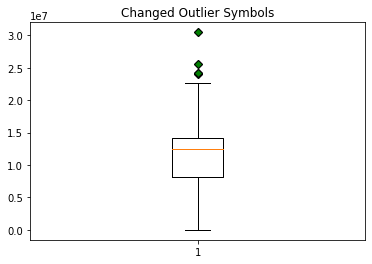

In [4]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig3, ax3 = plt.subplots()
ax3.set_title('Changed Outlier Symbols')
ax3.boxplot(x, flierprops=green_diamond)

# Scale the data

In [5]:
transformer = RobustScaler().fit(x)
transformed_x = transformer.transform(x)

In [6]:

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

transformed_X_train, transformed_X_test, y_train, y_test = train_test_split(transformed_x, y, test_size=0.2, random_state=1)
transformed_X_train, transformed_X_val, y_train, y_val = train_test_split(transformed_X_train, y_train, test_size=0.25, random_state=1)

## Linear Regression

In [ ]:
xmin = min(X_train)
xmax = max(X_train)
xx = np.arange(xmin,xmax, 100).reshape(-1,1)
fig, ax = plt.subplots()
ax.scatter(X_train, y_train, edgecolors=(0, 0, 0))

#using x as feature
lin_reg_linear = LinearRegression()

lin_reg_linear.fit(X_train, y_train)
prediction_linear_train = lin_reg_linear.predict(X_train)
prediction_linear_valid = lin_reg_linear.predict(X_val)

print("Mean Squared error of training data when feature x is used: ", mean_squared_error(y_train, prediction_linear_train))
print("Mean squared error of validation data when feature x is used: ", mean_squared_error(y_val, prediction_linear_valid))

yy_linear = lin_reg_linear.predict(xx)

#using x^2 as feature
lin_reg_poly = LinearRegression()

lin_reg_poly.fit(X_train**2, y_train)
prediction_poly_train = lin_reg_poly.predict(X_train)
prediction_poly_valid = lin_reg_poly.predict(X_val)

print("Mean Squared error of training data when feature x^2 is used: ", mean_squared_error(y_train, prediction_poly_train))
print("Mean squared error of validation data when feature x^2 is used: ", mean_squared_error(y_val, prediction_poly_valid))

yy_poly = lin_reg_poly.predict(xx)

#using x^3 as feature
lin_reg_cube = LinearRegression()

lin_reg_cube.fit(X_train**3, y_train)
prediction_cube_train = lin_reg_cube.predict(X_train)
prediction_cube_valid = lin_reg_cube.predict(X_val)

print("Mean Squared error of training data when feature x^3 is used: ", mean_squared_error(y_train, prediction_cube_train))
print("Mean squared error of validation data when feature x^3 is used: ", mean_squared_error(y_val, prediction_cube_valid))

yy_cube = lin_reg_cube.predict(xx)


#using sqrt x as feature
lin_reg_sqrt = LinearRegression()

lin_reg_sqrt.fit(np.sqrt(X_train), y_train)
prediction_sqrt_train = lin_reg_sqrt.predict(X_train)
prediction_sqrt_valid = lin_reg_sqrt.predict(X_val)

print("Mean Squared error of training data when feature sqrt(x) is used: ", mean_squared_error(y_train, prediction_sqrt_train))
print("Mean squared error of validation data when feature sqrt(x) is used: ", mean_squared_error(y_val, prediction_sqrt_valid))

yy_sqrt = lin_reg_sqrt.predict(xx)



ax.plot(xx,yy_linear)
ax.plot(xx,yy_poly)
ax.plot(xx,yy_cube)
ax.plot(xx,yy_sqrt)


ax.legend(['trained with x', 'trained with x^2', 'trained with x^3', 'trained with sqrt(x)'])


plt.title("Linear Regression")
plt.xlabel("Population of City")
plt.ylabel("Number of Visitors")
plt.show()




Mean Squared error of training data when feature x is used:  3192093377714.5225
Mean squared error of validation data when feature x is used:  1955994225902.8186


/anaconda3/envs/ivado/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


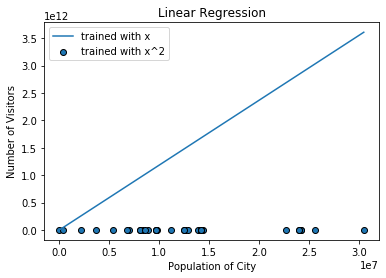

In [7]:
xmin = min(X_train)
xmax = max(X_train)
xx = np.arange(xmin,xmax, 100).reshape(-1,1)
fig, ax = plt.subplots()
ax.scatter(X_train, y_train, edgecolors=(0, 0, 0))
#using x as feature
lin_reg_linear = LinearRegression()

lin_reg_linear.fit(transformed_X_train, y_train)
prediction_linear_train = lin_reg_linear.predict(transformed_X_train)
prediction_linear_valid = lin_reg_linear.predict(transformed_X_val) ## not sure if this needs to be transformed validation data

print("Mean Squared error of training data when feature x is used: ", mean_squared_error(y_train, prediction_linear_train))
print("Mean squared error of validation data when feature x is used: ", mean_squared_error(y_val, prediction_linear_valid))

yy_linear = lin_reg_linear.predict(xx)
'''
#using x^2 as feature
lin_reg_poly = LinearRegression()

lin_reg_poly.fit(X_train**2, y_train)
prediction_poly_train = lin_reg_poly.predict(X_train)
prediction_poly_valid = lin_reg_poly.predict(X_val)

print("Mean Squared error of training data when feature x^2 is used: ", mean_squared_error(y_train, prediction_poly_train))
print("Mean squared error of validation data when feature x^2 is used: ", mean_squared_error(y_val, prediction_poly_valid))

yy_poly = lin_reg_poly.predict(xx)

#using x^3 as feature
lin_reg_cube = LinearRegression()

lin_reg_cube.fit(X_train**3, y_train)
prediction_cube_train = lin_reg_cube.predict(X_train)
prediction_cube_valid = lin_reg_cube.predict(X_val)

print("Mean Squared error of training data when feature x^3 is used: ", mean_squared_error(y_train, prediction_cube_train))
print("Mean squared error of validation data when feature x^3 is used: ", mean_squared_error(y_val, prediction_cube_valid))

yy_cube = lin_reg_cube.predict(xx)


#using sqrt x as feature
lin_reg_sqrt = LinearRegression()

lin_reg_sqrt.fit(np.sqrt(X_train), y_train)
prediction_sqrt_train = lin_reg_sqrt.predict(X_train)
prediction_sqrt_valid = lin_reg_sqrt.predict(X_val)

print("Mean Squared error of training data when feature sqrt(x) is used: ", mean_squared_error(y_train, prediction_sqrt_train))
print("Mean squared error of validation data when feature sqrt(x) is used: ", mean_squared_error(y_val, prediction_sqrt_valid))

yy_sqrt = lin_reg_sqrt.predict(xx)



ax.plot(xx,yy_linear)
ax.plot(xx,yy_poly)
ax.plot(xx,yy_cube)
ax.plot(xx,yy_sqrt)

'''
ax.plot(xx, yy_linear)

ax.legend(['trained with x', 'trained with x^2', 'trained with x^3', 'trained with sqrt(x)'])


plt.title("Linear Regression")
plt.xlabel("Population of City")
plt.ylabel("Number of Visitors")
plt.show()




Since the error is high, we will try forming new features such as $\sqrt{x}, (x)^2, (x)^3$, to be used by Linear Regression. 

## Decision Tree

In [ ]:
decision_tree = tree.DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)
prediction_train = decision_tree.predict(X_train)
print("The mean squared error(train) is: ", mean_squared_error(y_train, prediction_train))
prediction_valid = decision_tree.predict(X_val)
print("The mean squared error(validation) is: ", mean_squared_error(y_val, prediction_valid))
fig, ax = plt.subplots()
ax.scatter(X_train, y_train, edgecolors=(0, 0, 0))

yy = decision_tree.predict(xx)
ax.plot(xx,yy)
plt.title("Decision Tree")
plt.xlabel("Population of City")
plt.ylabel("Number of Visitors")
plt.show()

